# 06. Elf3 calling cards analysis

MOC1 cells were given interferon treatment and transfected with calling cards reagents. Forty-eight hours after transfection, selection was applied with puromycin. Cells were then harvested and calling cards libraries were prepared according to the [bulk calling cards protocol](https://www.protocols.io/view/bulk-calling-cards-library-preparation-dm6gp8y48lzp/v1).

## 0. Calling cards pre-processing

Raw reads were converted to unique Elf3 insertion (`.qbed`) files using `09_call_hops_bc.sh`.

For additional dependencies needed to run `09_call_hops_bc.sh`, please see [https://github.com/arnavm/calling_cards](https://github.com/arnavm/calling_cards).

## 1. Integrate and call peaks using the pyCallingCards suite

[https://pycallingcards.readthedocs.io/en/latest/user_guide/index.html](https://pycallingcards.readthedocs.io/en/latest/user_guide/index.html)

In [2]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import pycallingcards.plotting as pl
import pybedtools
plt.rcParams['figure.dpi'] = 150

In [4]:
# each condition was performed in triplicate
elf3 = cc.rd.read_qbed('path/to/1.qbed')
wt1 = cc.rd.read_qbed('path/to/.2qbed')
wt2 = cc.rd.read_qbed('path/to/.3qbed')
wt3 = cc.rd.read_qbed('path/to/.4qbed')
elf1 = cc.rd.read_qbed('path/to/.5qbed')
elf2 = cc.rd.read_qbed('path/to/.6qbed')

In [6]:
# merge replicates
WT = cc.rd.combine_qbed([wt1, wt2, wt3, wt1_novaseq, wt2_novaseq, wt3_novaseq])
ELF3 = cc.rd.combine_qbed([elf1, elf2, elf3, elf1_novaseq, elf2_novaseq, elf3_novaseq])

In [7]:
# format the qbed file
WT = cc.pp.clean_qbed(WT)
ELF3 = cc.pp.clean_qbed(ELF3)

In [50]:
# inspect Elf3 qbed file
ELF3

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,3011890,3011894,1,-,TCGTG/SIC88/GAAG
1,chr1,3042746,3042750,1,+,TCGTG/SIC81/GGAA
2,chr1,3052537,3052541,1,+,TCGTG/SIC80/TCAG
3,chr1,3055972,3055976,15,+,TCGTG/SIC88/TCAG
4,chr1,3055972,3055976,1,+,TCGTG/SIC88/GAGA
...,...,...,...,...,...,...
510055,chrY,90767493,90767497,48,-,TCGTG/SIC80/GGAA
510056,chrY,90784724,90784728,1,+,TCGTG/SIC82/GTCA
510057,chrY,90808770,90808774,1,+,TCGTG/SIC80/TCGA
510058,chrY,90818139,90818143,1,+,TCGTG/SIC88/TCGA


In [52]:
# save
ELF3.to_csv('Elf3_insertions.qbed')

In [3]:
ELF3 = pd.read_csv('/path/to/Elf3_insertions.qbed')

In [4]:
# convert insertions to bedgraph format for gene browser
# load insertions
insertions = ELF3

# create midpoints
insertions['mid'] = (insertions['Start'] + insertions['End']) // 2

# bin size
bin_size = 100

# create a new column for binned start positions
insertions['binned_start'] = (insertions['mid'] // bin_size) * bin_size
insertions['binned_end'] = insertions['binned_start'] + bin_size

# group by chr + bin
binned = insertions.groupby(['Chr', 'binned_start', 'binned_end']).size().reset_index(name='score')

# save as bedGraph
#binned.to_csv("Elf3_insertions_density.bedGraph", sep="\t", header=False, index=False)

In [9]:
# call peaks

peak_data = cc.pp.call_peaks(ELF3, WT, method = "MACCs", reference = "mm10",  window_size = 2000, step_size = 500,
                  pvalue_cutoffTTAA = 0.001, pvalue_cutoffbg = 0.1, lam_win_size = None,  pseudocounts = 0.1, record = True, save = "peaks.bed")
peak_data

For the MACCs method with background, [expdata, background, reference, pvalue_cutoffbg, pvalue_cutoffTTAA, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_insertions, record] would be utilized.


100%|███████████████████████████████████████████| 21/21 [01:04<00:00,  3.08s/it]


,Chr,Start,End,Center,Experiment Insertions,Background insertions,Reference Insertions,pvalue Reference,pvalue Background,Fraction Experiment,TPH Experiment,Fraction background,TPH background,TPH background subtracted,pvalue_adj Reference
0,chr1,5253411,5255311,5254775.5,6,8,11,6.974787e-07,0.056296,0.000012,1178.261083,0.000006,644.485620,533.775463,1.812748e-04
1,chr1,6306433,6307568,6306987.0,19,27,12,0.000000e+00,0.010746,0.000037,3731.160096,0.000022,2175.138967,1556.021129,0.000000e+00
2,chr1,7497673,7498743,7498540.0,8,7,7,1.155384e-10,0.003553,0.000016,1571.014777,0.000006,563.924917,1007.089860,5.029800e-08
3,chr1,8158269,8159968,8159765.0,6,7,14,2.496934e-06,0.031937,0.000012,1178.261083,0.000006,563.924917,614.336166,5.956232e-04
4,chr1,9148949,9150406,9149633.0,6,7,8,1.398659e-07,0.031937,0.000012,1178.261083,0.000006,563.924917,614.336166,4.056615e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7757,chrY,85091998,85093378,85092198.0,7,9,12,4.913625e-12,0.011039,0.000014,1374.637930,0.000007,725.046322,649.591608,2.407047e-09
7758,chrY,89127477,89128858,89128655.0,7,7,13,6.054379e-12,0.002752,0.000014,1374.637930,0.000006,563.924917,810.713013,2.940934e-09
7759,chrY,89927987,89928876,89928442.0,5,8,11,1.080480e-08,0.052124,0.000010,981.884236,0.000006,644.485620,337.398616,3.719219e-06
7760,chrY,90505386,90507548,90507345.0,5,4,10,9.163515e-09,0.002888,0.000010,981.884236,0.000003,322.242810,659.641426,3.185481e-06


In [51]:
# save peaks
peak_data.to_csv('Elf3_peaks.csv')

## 2. Call motifs from Elf3 insertions

In [13]:
# call motifs using pyCallingCards
cc.tl.call_motif("peaks.bed",reference ="mm10",save_homer = "Homer_novaseq/peaks",
                 homer_path = "/usr/local/Caskroom/mambaforge/base/envs/pycallingcards/bin/", num_cores=12)

Peak data peaks.bed is used here.



	Position file = peaks.bed
	Genome = mm10
	Output Directory = Homer_novaseq/peaks
	Fragment size set to 1000
	Using 12 CPUs
	Will not run homer for de novo motifs
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 7762
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 7762
		Redundant Peak IDs: 1
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Redunant Peaks found: Remove or rename these or some programs may have trouble...

	1 duplicate peak IDs out of 7762 total peaks
	Background files for 1000 bp fragments found.
	Custom genome sequence directory: /usr/local/Caskroom/mambaforge/base/envs/pycallingcards/share/homer-4.10-0/.//data/genomes/mm10//

	Extracting sequences from directory: /usr/local/Caskroom/mambaforge/base/envs/pycallingcards/share/

Finished!



	Preparing HTML output with sequence logos...
		1 of 428 (1e-261) Fosl2(bZIP)/3T3L1-Fosl2-ChIP-Seq(GSE56872)/Homer
		2 of 428 (1e-254) Fra2(bZIP)/Striatum-Fra2-ChIP-Seq(GSE43429)/Homer
		3 of 428 (1e-236) JunB(bZIP)/DendriticCells-Junb-ChIP-Seq(GSE36099)/Homer
		4 of 428 (1e-236) Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer
		5 of 428 (1e-228) Fra1(bZIP)/BT549-Fra1-ChIP-Seq(GSE46166)/Homer
		6 of 428 (1e-216) Jun-AP1(bZIP)/K562-cJun-ChIP-Seq(GSE31477)/Homer
		7 of 428 (1e-207) BATF(bZIP)/Th17-BATF-ChIP-Seq(GSE39756)/Homer
		8 of 428 (1e-200) ELF3(ETS)/PDAC-ELF3-ChIP-Seq(GSE64557)/Homer
		9 of 428 (1e-192) AP-1(bZIP)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer
		10 of 428 (1e-188) ELF5(ETS)/T47D-ELF5-ChIP-Seq(GSE30407)/Homer
		11 of 428 (1e-184) Elf4(ETS)/BMDM-Elf4-ChIP-Seq(GSE88699)/Homer
		12 of 428 (1e-178) EHF(ETS)/LoVo-EHF-ChIP-Seq(GSE49402)/Homer
		13 of 428 (1e-168) ETV4(ETS)/HepG2-ETV4-ChIP-Seq(ENCODE)/Homer
		14 of 428 (1e-162) ETV1(ETS)/GIST48-ETV1-ChIP-Seq(GSE22441)/Homer
		15 of 

## 3. Plot Elf3 insertions with ATAC-seq data

In [13]:
import pyBigWig

In [14]:
# read in and format files
GTF = "/path/to/mm10.refGene.gtf"
INSERTION_BED = "/path/to/Elf3_insertions.qbed"
PEAK_BED = "/path/to/peaks.bed"
insertion_bed_simple = "/path/to/insertions_for_tracks.bed"

bws = {"MOC1ifn": "/path/to/MOC1ifn_merged.bw",
       "MOC1veh": "/path/to/MOC1veh_merged.bw"}

genes_df = load_genes_from_gtf("/path/to/mm10.refGene.gtf")
peaks_df = load_peaks(PEAK_BED)

In [23]:
# define functions

def load_genes_from_gtf(gtf_file):
    """
    load transcript-level gene annotations from a GTF file into a DataFrame
    """
    genes = []
    with open(gtf_file) as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.strip().split('\t')
            if len(fields) < 9 or fields[2] != "transcript":
                continue
            chrom = fields[0]
            start = int(fields[3])
            end = int(fields[4])
            strand = fields[6]
            attr = fields[8]
            
            gene_name = None
            for part in attr.split(';'):
                if 'gene_name' in part:
                    gene_name = part.split('"')[1]
                    break
            if gene_name is None:
                for part in attr.split(';'):
                    if 'gene_id' in part:
                        gene_name = part.split('"')[1]
                        break
            if gene_name is not None:
                genes.append((chrom, start, end, gene_name, strand))
    
    return pd.DataFrame(genes, columns=["Chr", "Start", "End", "Gene", "Strand"])
    
def load_peaks(bed_file):
    """
    load genomic intervals from a BED file into a DataFrame with Chr, Start, End columns
    """
    return pd.read_csv(bed_file, sep='\t', header=None, usecols=[0, 1, 2], names=["Chr", "Start", "End"])

def load_insertions(qbed_file):
    """
    load insertion data from a qBED file into a DataFrame with relevant columns
    """
    columns = ["Chr", "Start", "End", "Reads", "Direction", "Barcodes"]
    insertions = pd.read_csv(qbed_file, header=0)
    insertions = insertions[columns]
    return insertions

def plot_insertions(ax, insertions, chrom, start, end, dot_size=10, dot_color='red', shift_bp=0):
    """
    plot insertions as log-scaled dots on the specified genomic region
    """
    region = insertions[
        (insertions['Chr'] == chrom) &
        (insertions['Start'] >= start) &
        (insertions['Start'] <= end)
    ]
    x = (region['Start'] + region['End']) / 2 + shift_bp 
    y = np.log1p(region['Reads'])
    ax.scatter(x, y, s=dot_size, color=dot_color, label="Insertions", alpha=0.7)
    ax.set_ylabel('log(reads + 1)')
    ax.set_xlim(start, end)

def plot_peaks(ax, peaks_df, chrom, start, end, peak_color='gray'):
    """
    draw shaded boxes representing peak regions overlapping the specified interval
    """
    region_peaks = peaks_df[
        (peaks_df['Chr'] == chrom) &
        (peaks_df['Start'] < end) &
        (peaks_df['End'] > start)
    ]
    
    for _, row in region_peaks.iterrows():
        ax.axvspan(row['Start'], row['End'], ymin=0, ymax=1, color=peak_color, alpha=0.5)
    
    ax.set_ylim(0, 1)
    ax.axis('off')

def plot_bigwig(ax, bw_file, chrom, start, end, color='black', label=None):
    """
    plot BigWig signal as a filled line over the specified region
    """
    bw = pyBigWig.open(bw_file)
    values = bw.values(chrom, start, end, numpy=True)
    x = np.arange(start, start + len(values))  # precise matching of coordinates
    ax.fill_between(x, values, step='mid', color=color, alpha=0.6)
    bw.close()
    ax.set_ylabel('Signal')
    ax.set_xlim(start, end)

def plot_genes(ax, genes_df, chrom, start, end, font_size=8):
    """
    draw gene models with directional arrows and names along the genomic interval
    """
    region_genes = genes_df[
        (genes_df["Chr"] == chrom) &
        (genes_df["Start"] < end) &
        (genes_df["End"] > start)
    ]
    
    y_levels = [0.3, 0.5, 0.7]  # y-positions to stagger labels
    for i, row in enumerate(region_genes.itertuples()):
        y = y_levels[i % len(y_levels)]
        gene_start = max(start, row.Start)
        gene_end = min(end, row.End)
        mid = (gene_start + gene_end) // 2

        ax.plot([gene_start, gene_end], [y, y], color='black', lw=1)
        arrow_length = (gene_end - gene_start) * 0.05
        if row.Strand == '+':
            ax.annotate('', xy=(gene_end, y), xytext=(gene_end - arrow_length, y),
                        arrowprops=dict(arrowstyle="->", color='black'))
        else:
            ax.annotate('', xy=(gene_start, y), xytext=(gene_start + arrow_length, y),
                        arrowprops=dict(arrowstyle="->", color='black'))
        ax.text(mid, y + 0.05, row.Gene, fontsize=font_size, ha='center')
    
    ax.set_ylim(0, 1)
    ax.axis('off')

def plot_insertions_and_bigwigs(qbed_file, bigwig_files_dict, chrom, start, end,
                                dot_size=10, dot_color='red',
                                bigwig_colors=None, genes_df=None, peaks_df=None,
                                figsize=(15, 10), peak_color='gray',
                                track_heights=[1, 0.4, 2, 0.8], padding=0.05,
                                save_path=None, dpi=300):
    """
    generate a multi-track plot showing insertions, 
    calling cards peaks, BigWig signal, and gene annotations
    """
    insertions = load_insertions(qbed_file)
    
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=figsize,
                            gridspec_kw={'height_ratios': track_heights})
    ax1, ax2, ax3, ax4 = axs

    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', bottom=False, labelbottom=False)

    # Insertions
    plot_insertions(ax1, insertions, chrom, start, end, dot_size, dot_color)

    # Peaks
    if peaks_df is not None:
        plot_peaks(ax2, peaks_df, chrom, start, end, peak_color=peak_color)

    # BigWigs
    bigwig_labels = list(bigwig_files_dict.keys())
    bigwig_paths = list(bigwig_files_dict.values())
    if bigwig_colors is None:
        bigwig_colors = ['black'] * len(bigwig_paths)
    for label, path, color in zip(bigwig_labels, bigwig_paths, bigwig_colors):
        plot_bigwig(ax3, path, chrom, start, end, color=color)

    # Genes
    if genes_df is not None:
        plot_genes(ax4, genes_df, chrom, start, end)
    ax4.set_xlabel(f"{chrom}:{start}-{end}")

    plt.subplots_adjust(hspace=padding+.1)
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

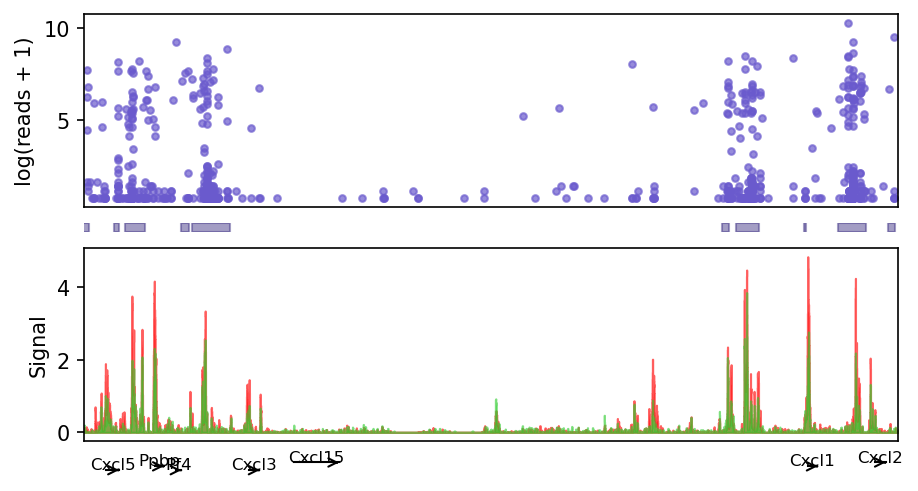

In [16]:
# plot at C-X-C locus

padding = 0.05

plot_insertions_and_bigwigs(
    qbed_file=INSERTION_BED,
    bigwig_files_dict=bws,
    chrom="chr5",
    start=90755157,
    end=90908303,
    dot_size=10,
    dot_color='slateblue',
    bigwig_colors=['red', 'limegreen'],
    genes_df=genes_df,
    peaks_df=peaks_df,
    peak_color='darkslateblue',
    figsize=(7, 4),
    track_heights=[0.2, 0.01, 0.2, 0.02],
    #save_path="Elf3_CC_CXC_locus.png",
    dpi=300
)

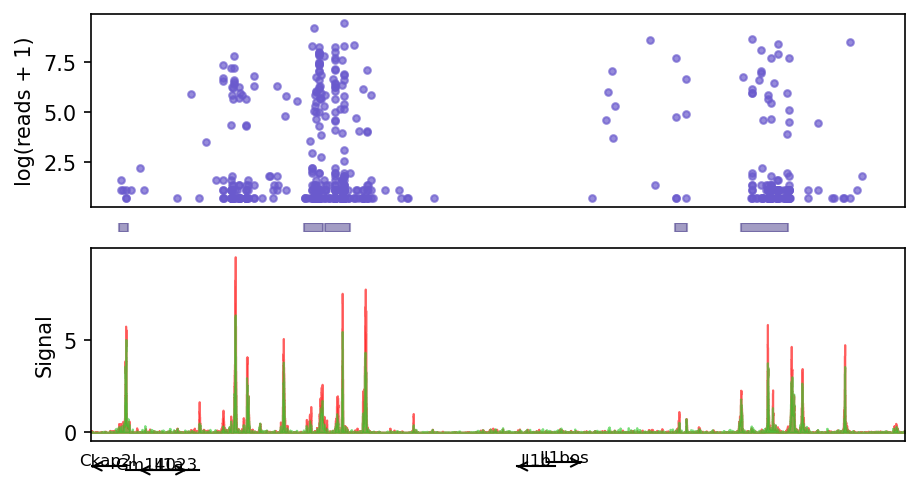

In [17]:
# plot at IL-1 locus

padding = 0.05

plot_insertions_and_bigwigs(
    qbed_file=INSERTION_BED,
    bigwig_files_dict=bws,
    chrom="chr2",
    start=129291362,
    end=129431351,
    dot_size=10,
    dot_color='slateblue',
    bigwig_colors=['red', 'limegreen'],
    genes_df=genes_df,
    peaks_df=peaks_df,
    peak_color='darkslateblue',
    figsize=(7, 4),
    track_heights=[0.2, 0.01, 0.2, 0.02],
    #save_path="Elf3_CC_Il1_locus.png",
    dpi=300
)

## 4. Calculate enrichment of ICB-resistance TSSs in Elf3 binding data

In [21]:
ICBres = [
    "Prss27", "Desi1", "Ltf", "Pglyrp4", "Pdzk1ip1", "Spns2", "Psca", "Prss22", "Tmprss11g",
    "Gsto1", "Krt19", "Muc20", "Tspan1", "Duoxa2", "Gm13056", "Tmc5", "Ecm1", "Cblc", "Gm9573", 
    "AA467197", "Capn5", "Glrx", "Spns3", "Tmprss11e", "Gm14137", "Trp53inp2", "Slc6a14", "Dynap", 
    "Dusp4", "Cldn23", "AI661453", "Clic5", "Grpel2", "Apol7a", "Gde1", "Mal", "Duox2", "Nupr1", 
    "Cldn1", "P2ry2", "Irf7", "S100a14", "Cdkn2b", "Mall", "Plekhs1", "AC168977.1", "Muc4", "Fxyd4", 
    "Ly6m", "Trim15", "Mal2", "Wnt7b", "Ift22", "Plet1", "Ppbp", "Hist1h1c", "Cryba4", "Krt7", "Hsd17b7", 
    "Clca3b", "Tmprss11f", "Serpinb9f", "Gm48975", "Myzap", "Slc9a3r1", "Pttg1ip", "Slc28a3", "Cidea", 
    "Gm13074", "Gm20234", "Arg1", "4930459C07Rik", "Bspry", "Ccdc12", "Pigr", "Krt23", "1810044K17Rik", 
    "Cyp2d10", "Pbp2", "Cxcl5", "Tmprss4", "Lpcat4", "Ccdc71l", "Arhgap27os1", "Eps8l2", "Tmprss11b", 
    "Serpinb9g", "Csf3", "Ifit1bl1", "Liph", "Ephb3", "AA986860", "Lgals3", "Rassf7", "Gm49439", "Grhl1", 
    "Gfpt1", "Trim16", "Sprr2d"
]

Observed total Elf3 insertions ±5000bp of program TSSs: 1362
Empirical p-value: 0.029


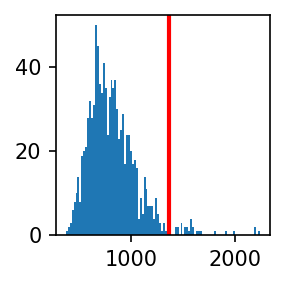

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybedtools import BedTool

# read in TSS bed file, insertions, ATAC signal .tab file from ATAC data
ALL_TSS_BED      = "/path/to/mm10.refGene.TSS.bed"
INSERTIONS_BED   = "/path/to/insertions_for_tracks.bed"
ATAC_SIGNAL_TAB  = "/path/to/atac_signal_MOC1ifn_5kb.tab"

# your gene set of interest:
PROGRAM_GENES = ICBres

WINDOW           = 5000     # +/- window in bp around each TSS
N_PERMUTATIONS   = 1000      # how many permutations
N_BINS           = 1       # quantile bins for ATAC matching

# define relevant functions
def load_tss(bed_path):
    """
    create a dataframe with tss information
    """
    df = pd.read_csv(bed_path, sep="\t", header=None,
                     names=["chrom","start","end","gene"])
    df["tss"] = df["start"]
    return df

def window_tss(df, window):
    """
    create a genomic window of ±window (set by user) bp around each TSS
    """
    df = df.copy()
    df["start_w"] = (df["tss"] - window).clip(lower=0)
    df["end_w"]   =  df["tss"] + window
    return df

def count_insertions(genes_df, insertions_bt):
    """
    count the number of insertions overlapping each TSS window
    """
    tb = BedTool.from_dataframe(genes_df[["chrom","start_w","end_w","gene"]])
    out = tb.intersect(insertions_bt, c=True).to_dataframe(
        names=["chrom","start","end","gene","count"]
    )
    return out.set_index("gene")["count"]

def sample_matched_controls(program_genes, atac_df, n_bins, random_state):
    """
    sample control genes matched by ATAC signal bin to the input program genes
    """
    # assign each gene to an ATAC‐signal quantile bin
    df = atac_df.copy()
    df["bin"] = pd.qcut(df["signal"], q=n_bins, labels=False, duplicates="drop")
    # count how many of your program genes fall in each bin
    bin_counts = (
        df[df["gene"].isin(program_genes)]
        .groupby("bin")["gene"].count()
        .to_dict()
    )
    # sample the same number from each bin (excluding program_genes)
    controls = []
    for b, cnt in bin_counts.items():
        pool = df[(df["bin"] == b) & (~df["gene"].isin(program_genes))]["gene"]
        sampled = pool.sample(cnt, random_state=random_state)
        controls.extend(sampled.tolist())
    return controls

# organize results
all_tss       = load_tss(ALL_TSS_BED)
all_w         = window_tss(all_tss, WINDOW)
insertions_bt = BedTool(INSERTIONS_BED)

# load ATAC signal (output of bigWigAverageOverBed)
# columns: gene, size, covered, sum, mean0, mean_signal
atac = pd.read_csv(ATAC_SIGNAL_TAB, sep="\t", header=None,
                   names=["gene","size","covered","sum","mean0","signal"])
atac_signal_df = atac[["gene","signal"]]

# report # of insertions found near ICB-resistance TSSs
obs_df    = all_w[all_w["gene"].isin(PROGRAM_GENES)]
obs_total = count_insertions(obs_df, insertions_bt).sum()
print(f"Observed total Elf3 insertions ±{WINDOW}bp of program TSSs: {obs_total}")

# run permutations of random gene sets
perm_totals = []
for i in range(N_PERMUTATIONS):
    ctrls = sample_matched_controls(PROGRAM_GENES, atac_signal_df, N_BINS, random_state=i)
    ctrl_df = all_w[all_w["gene"].isin(ctrls)]
    perm_totals.append(count_insertions(ctrl_df, insertions_bt).sum())

# calculate p value for ICB-res enrichment
perm_totals = np.array(perm_totals)
p_empirical = ((perm_totals >= obs_total).sum() + 1) / (N_PERMUTATIONS + 1)
print(f"Empirical p-value: {p_empirical:.3f}")

# create plot
plt.figure(figsize=(2,2))
plt.hist(perm_totals, bins=100, alpha=1)
plt.axvline(obs_total, color="red", linewidth=2,
            label=f"program (obs={obs_total})")
plt.xlabel(f"")
plt.ylabel("")
plt.title("")
plt.legend(title=f"p = {p_empirical:.3f}").remove()
plt.tight_layout()
#plt.savefig('Elf3_hops_expected_ICBres.png', dpi = 600)
plt.show()
